# Step Size Analysis (step_size=0.1)

In [1]:
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import scipy
import sys

from collections import defaultdict
from datetime import datetime
from typing import Any, Dict, List, Tuple, TypedDict

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.constants import fMRIData
from feeg_fmri_sync.models import HemodynamicModel
from feeg_fmri_sync.plotting import (
    plot_all_search_results,
    plot_all_search_results_2d,
    plot_all_search_results_one_graph,
    plot_local_minima
)
from feeg_fmri_sync.search import get_suitable_range, search_voxels
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
    get_est_hemodynamic_response,
    get_ratio_eeg_freq_to_fmri_freq,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel, VectorizedSumEEGHemodynamicModel


from tests.helpers import (
    load_test_eeg_with_nans,
    load_test_eeg_without_nans,
    load_simulated_raw_fmri,
    generate_downsampled_simulated_fmri,
    generate_summed_simulated_fmri,
)

In [2]:
class ModelToFMRI(TypedDict):
    name: str
    fmri_data_options: Dict[str, fMRIData]
    fmri_to_plot: List[str]

In [3]:
try_to_reuse = True

## Initialize constants for Hemodynamic Modeling

In [4]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_tr_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=1.25
expected_alpha=2

time_steps = np.arange(hemodynamic_response_window*sample_freq + 1) / sample_freq
hrf = get_est_hemodynamic_response(time_steps, expected_delta, expected_tau, expected_alpha)
r_fmri = get_ratio_eeg_freq_to_fmri_freq(sample_freq, tr)

In [5]:
# eeg data types to use - with or without missing data
# Data will always be estimated without missing data
eeg_data_options = {
    'without_nans': load_test_eeg_without_nans(sample_frequency=sample_freq),
    'with_nans': load_test_eeg_with_nans(sample_frequency=sample_freq),
}

# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = {
    VectorizedHemodynamicModel: {
        'name': 'downsample',
        'fmri_data_generator': generate_downsampled_simulated_fmri
    }
}

## Display Generated Noise against Simulated Ground Truth

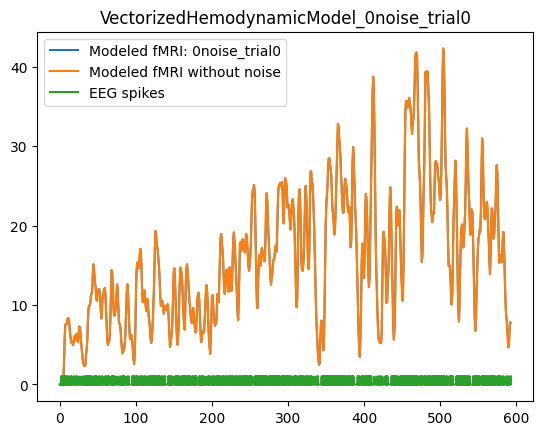

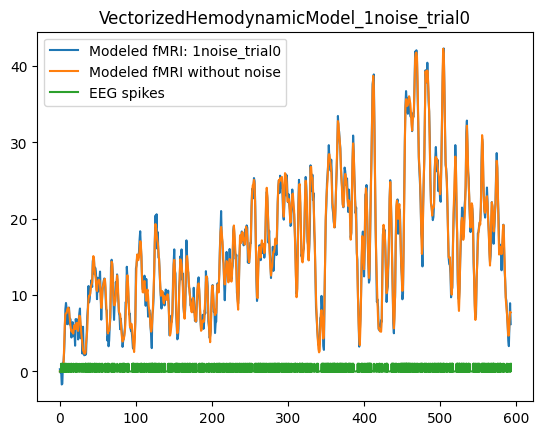

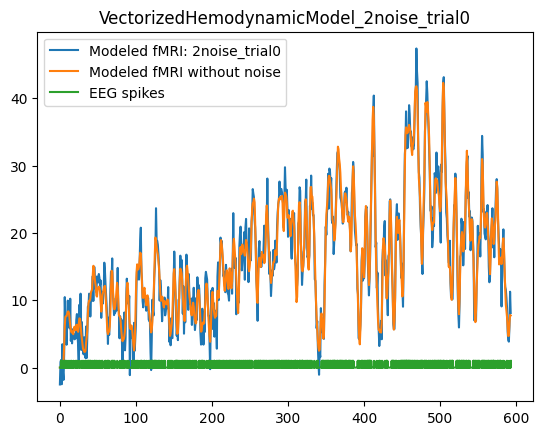

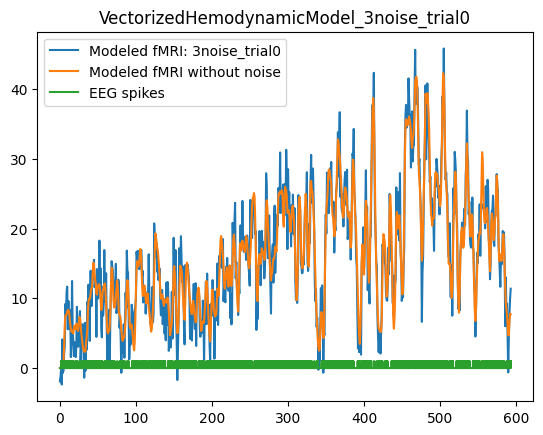

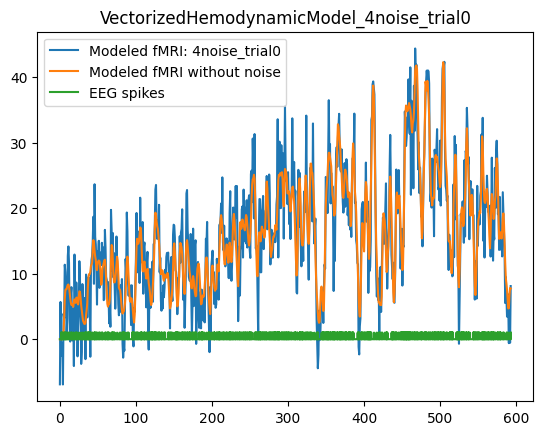

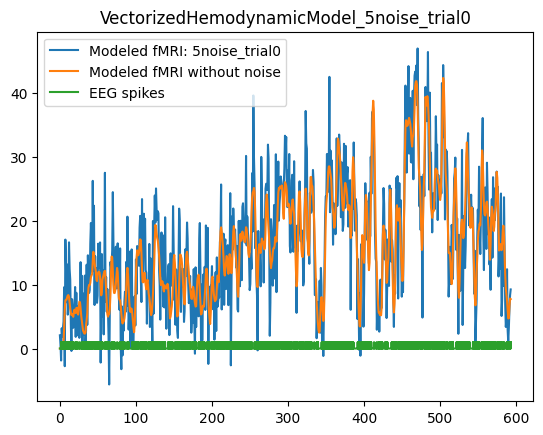

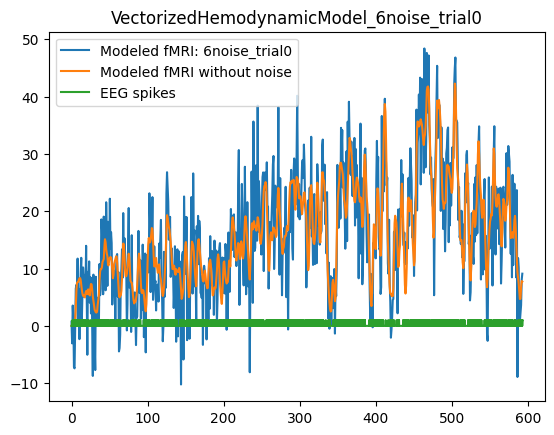

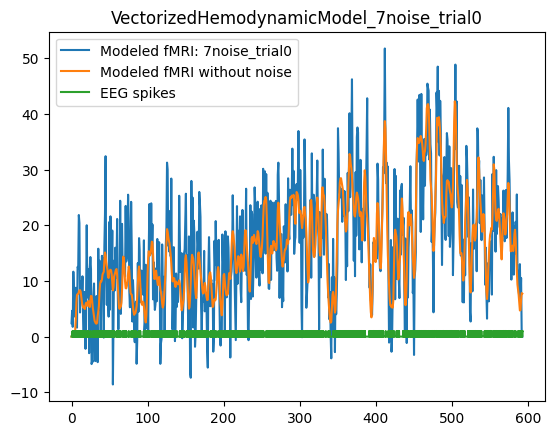

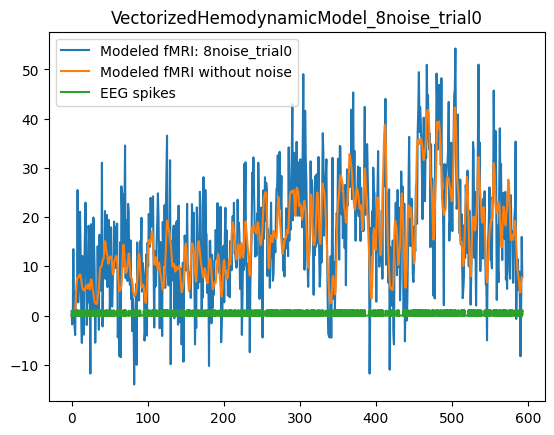

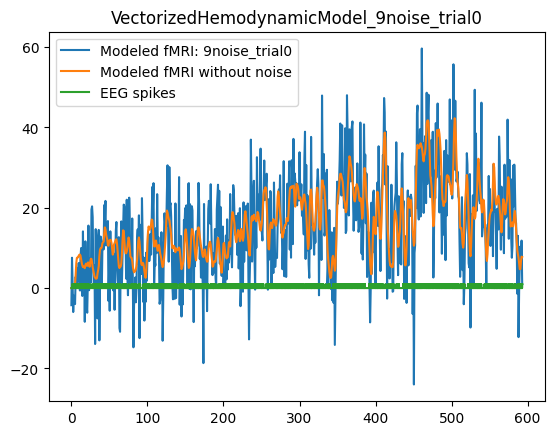

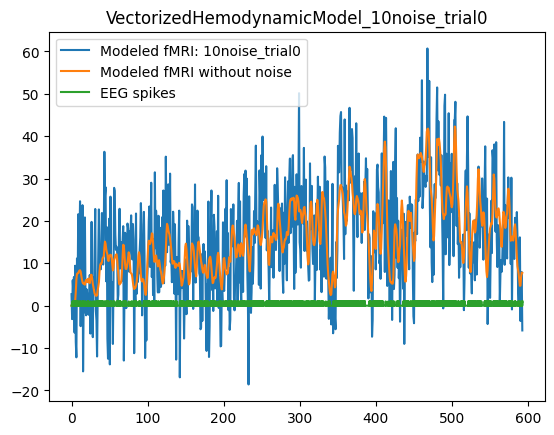

In [6]:
model_to_fmri = dict()

for model, attrs in models_to_test.items():
    fmri_data_options = {}
    fmri_to_plot = []
    name = f'0noise_trial0'
    fmri_data_options[name] = attrs['fmri_data_generator'](
        tr, 
        r_fmri, 
        eeg_data_options['without_nans'],
        hrf,
        0,
        plot=plot_generated_data,
        title=f'{model.__name__}_{name}',
        name = name,
    )
    if plot_perfect_comparison:
        fmri_to_plot.append(name)
    for trial in range(num_trials):
        for noise in noise_range:
            name = f'{noise}noise_trial{trial}'
            fmri_data_options[name] = attrs['fmri_data_generator'](
                tr, 
                r_fmri, 
                eeg_data_options['without_nans'],
                hrf,
                noise,
                plot=plot_generated_data if trial==0 else False,
                title=f'{model.__name__}_{name}',
                name=name
            )
            if noise in noises_to_plot and trial < num_trials_to_plot:
                fmri_to_plot.append(name)
    model_to_fmri[model] = ModelToFMRI(
        name=attrs['name'],
        fmri_data_options=fmri_data_options,
        fmri_to_plot=fmri_to_plot
    )


In [7]:
step_size = 0.1

filename_substring = f'effect_of_step_size_{step_size}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7
 2.8 2.9 3. ]

Tau target: 1.25, Range:
[0.75 0.85 0.95 1.05 1.15 1.25 1.35 1.45 1.55 1.65 1.75]

Alpha target: 2, Range:
[1.75 1.85 1.95 2.05 2.15 2.25 2.35]



In [8]:
models = {}
for hemodynamic_model in model_to_fmri:
    fmri_names = [fmri_name for fmri_name in model_to_fmri[hemodynamic_model]['fmri_data_options'].keys()]
    fmri_data = np.array([fmri.data for fmri in model_to_fmri[hemodynamic_model]['fmri_data_options'].values()])
    fmri = fMRIData(data=fmri_data, TR=tr, voxel_names=fmri_names)
    for eeg_data_name, eeg_data in eeg_data_options.items():
        name = f'{model_to_fmri[hemodynamic_model]["name"]}_{eeg_data_name}'
        models[name] = hemodynamic_model(
            eeg=eeg_data,
            fmri=fmri,
            name=name,
            n_tr_skip_beg=n_tr_skipped_at_beginning,
            hemodynamic_response_window=hemodynamic_response_window,
            plot=plot
        )
        models[name].set_plot_voxels(model_to_fmri[hemodynamic_model]['fmri_to_plot']) 


## Est vs Actual for all models at correct points

Scoring downsample_without_nans delta=2.25, tau=1.25, alpha=2


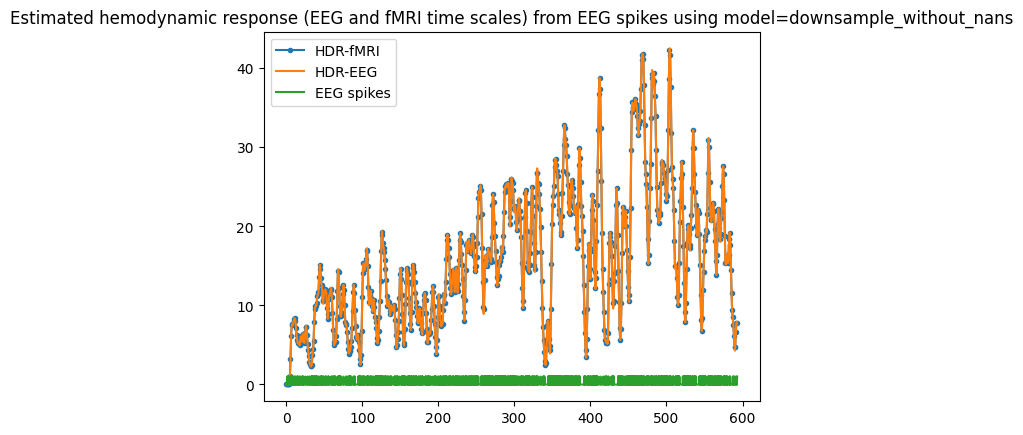

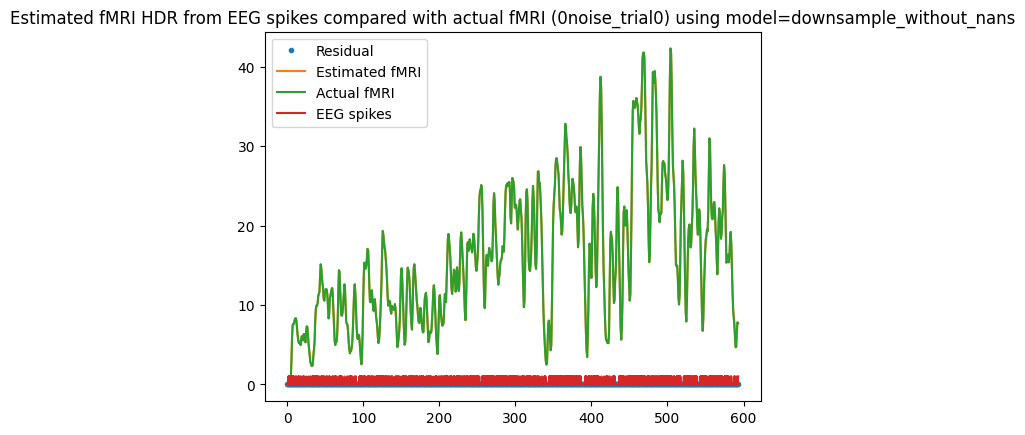

Residual Variance is 0.000000


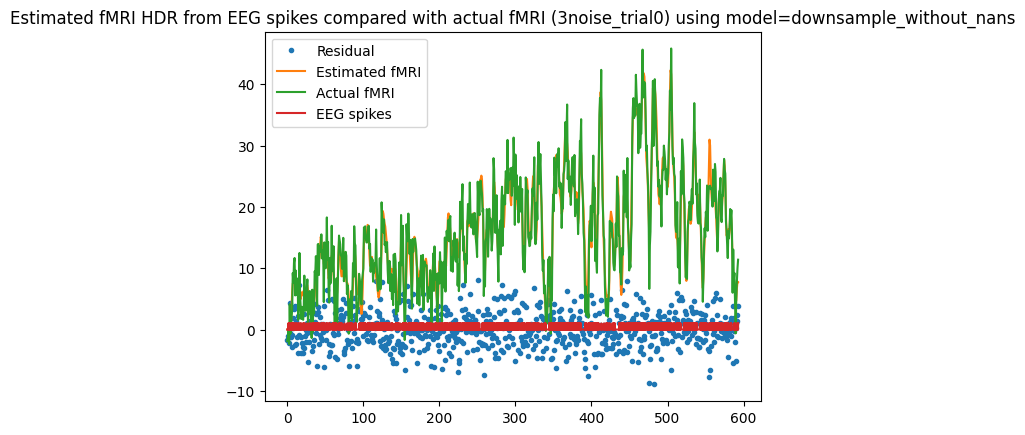

Residual Variance is 8.300189


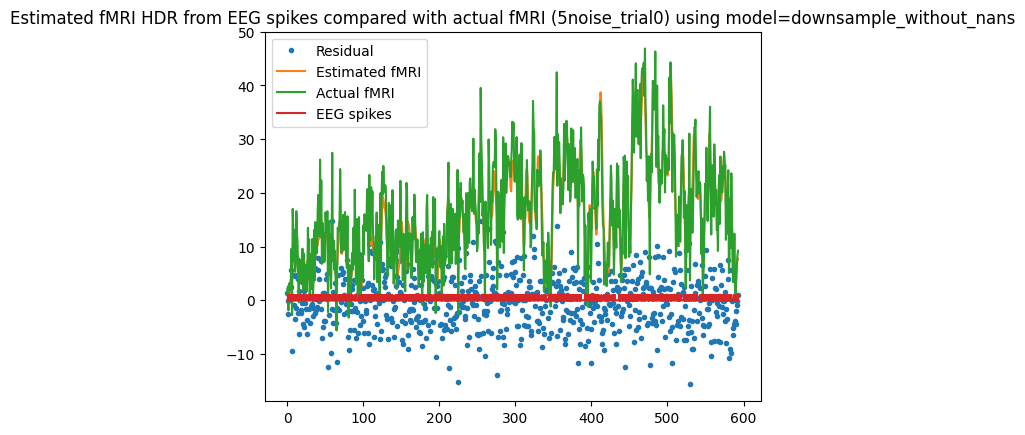

Residual Variance is 25.223245


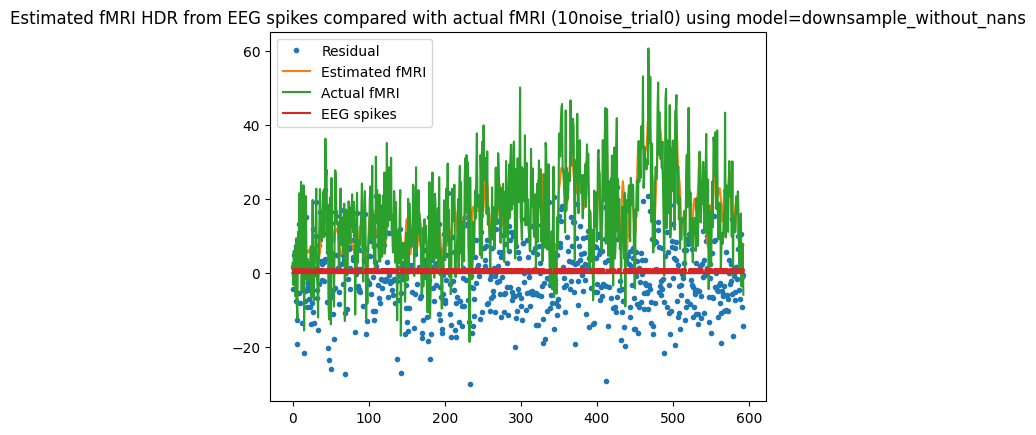

Residual Variance is 97.049317


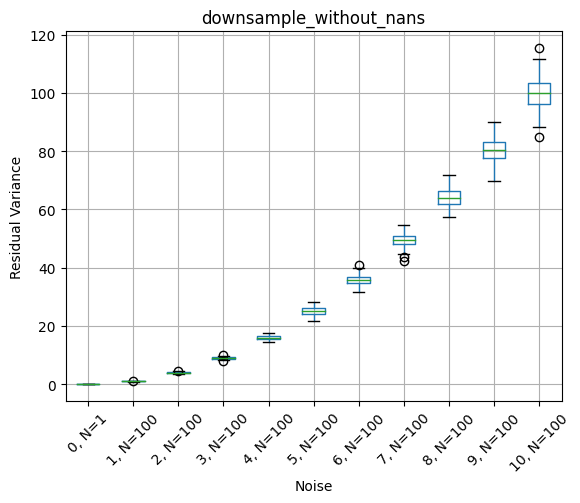

Scoring downsample_with_nans delta=2.25, tau=1.25, alpha=2


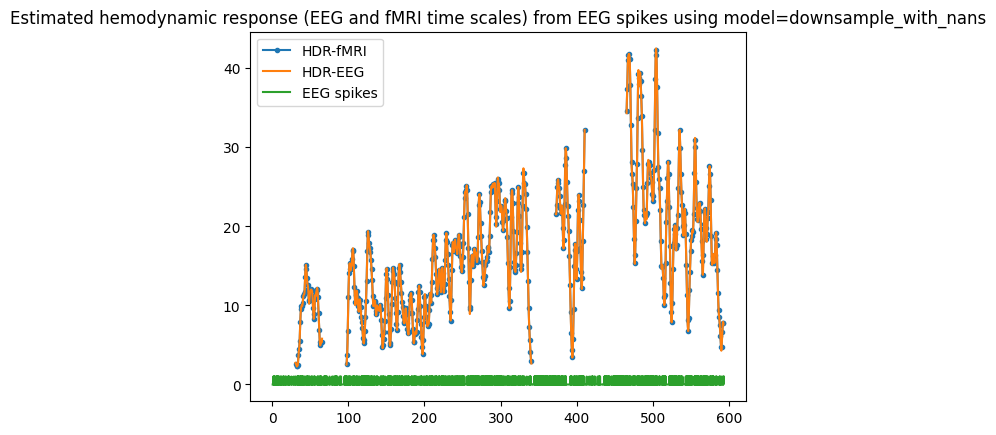

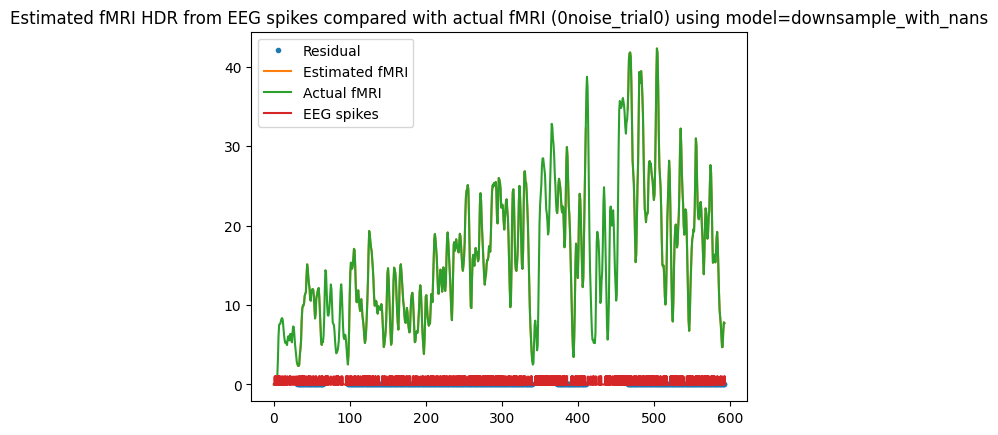

Residual Variance is 0.000000


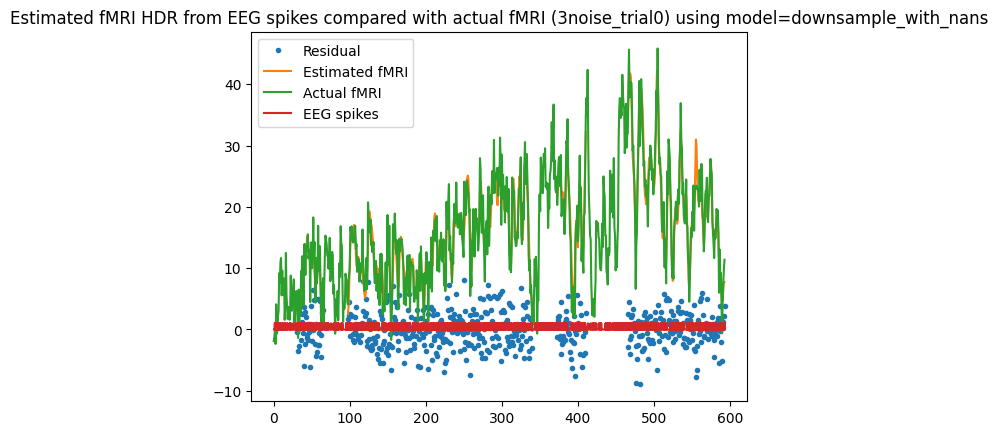

Residual Variance is 8.404649


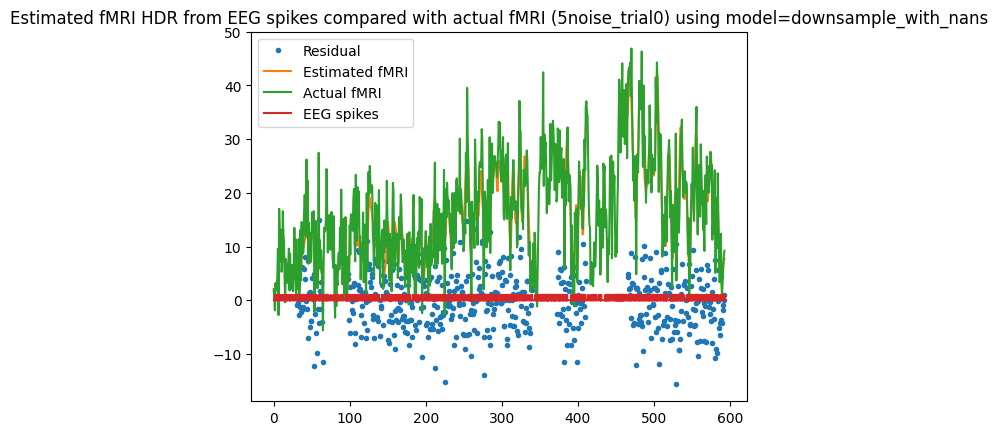

Residual Variance is 27.010565


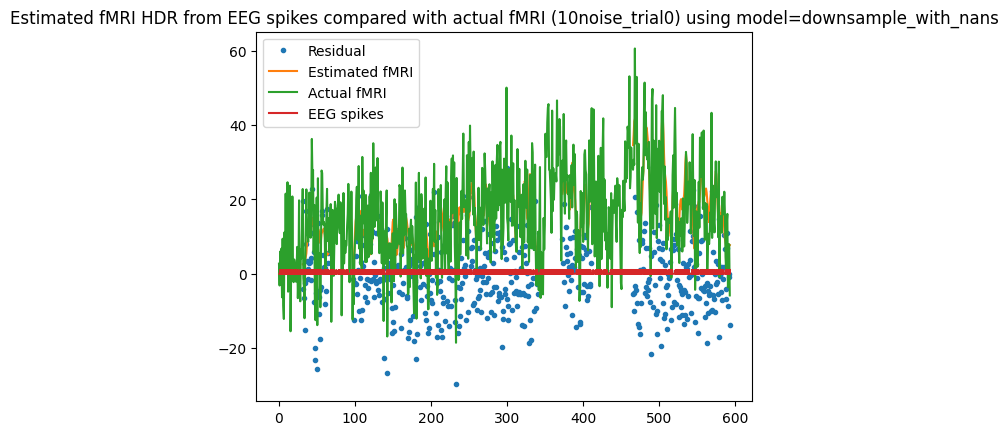

Residual Variance is 93.931854


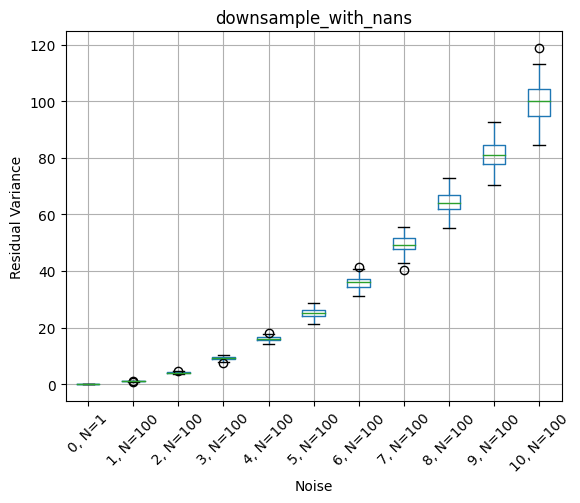

In [9]:
# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False


## Generate/Load the full dataset

In [10]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [11]:
if df.empty:
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)



Generating data!
Scoring delta=1.0
Scoring delta=1.1
Scoring delta=1.2000000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.6000000000000005
Scoring delta=1.7000000000000006
Scoring delta=1.8000000000000007
Scoring delta=1.9000000000000008
Scoring delta=2.000000000000001
Scoring delta=2.100000000000001
Scoring delta=2.200000000000001
Scoring delta=2.300000000000001
Scoring delta=2.4000000000000012
Scoring delta=2.5000000000000013
Scoring delta=2.6000000000000014
Scoring delta=2.7000000000000015
Scoring delta=2.8000000000000016
Scoring delta=2.9000000000000017
Scoring delta=3.0000000000000018


## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans) = 0.003171408176861751; at
      delta   tau  alpha
1924    2.2  1.25   2.05


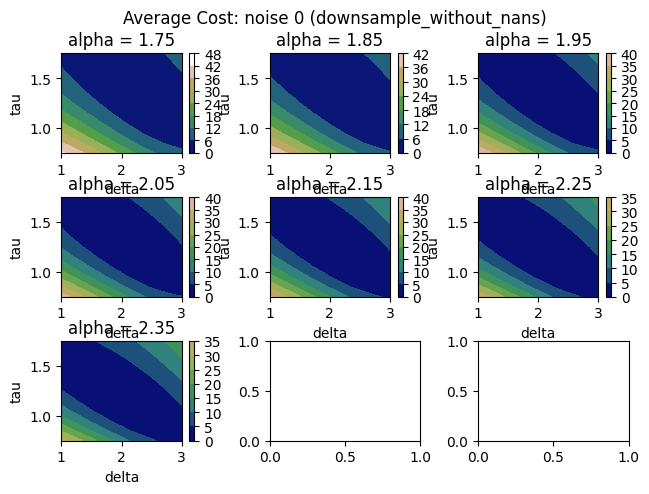

delta   tau  alpha  Average Cost: noise 0 (downsample_without_nans)
0       1.0  0.75   1.75                                        43.017811
2       1.0  0.75   1.85                                        41.301824
4       1.0  0.75   1.95                                        39.554209
6       1.0  0.75   2.05                                        37.780827
8       1.0  0.75   2.15                                        35.987850
...     ...   ...    ...                                              ...
3224    3.0  1.75   1.95                                        12.035360
3226    3.0  1.75   2.05                                        13.612216
3228    3.0  1.75   2.15                                        15.190117
3230    3.0  1.75   2.25                                        16.757261
3232    3.0  1.75   2.35                                        18.303650

[1617 rows x 4 columns]

In [51]:
model_name = 'downsample_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [70]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    2.2  1.25   2.05

### Local Minima Analysis

In [71]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


noise iteration      cost  delta   tau  alpha
0      0         0  0.008849    2.1  1.15   2.35
1      0         0  0.003171    2.2  1.25   2.05
2      0         0  0.029532    2.3  1.35   1.75

In [72]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [73]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [74]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [75]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [76]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [77]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration      cost  delta   tau  alpha
2      0         0  0.029532    2.3  1.35   1.75

In [79]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta   tau  alpha
0      0         0  0.008849    2.1  1.15   2.35

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_with_nans) = 0.0031312701555072557; at
      delta   tau  alpha
1925    2.2  1.25   2.05


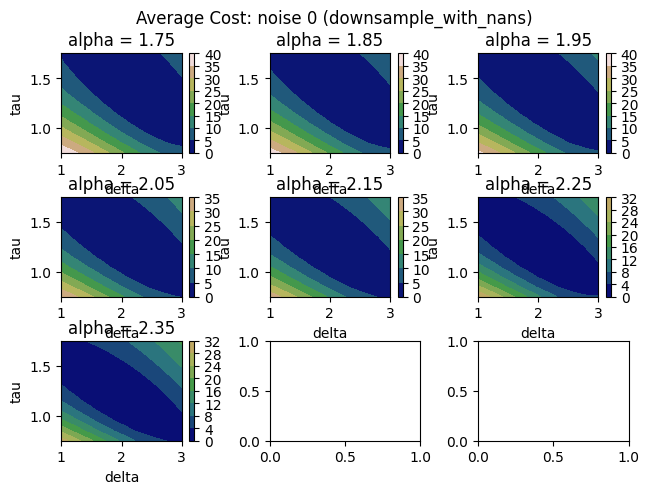

delta   tau  alpha  Average Cost: noise 0 (downsample_with_nans)
1       1.0  0.75   1.75                                     39.269201
3       1.0  0.75   1.85                                     37.799030
5       1.0  0.75   1.95                                     36.290082
7       1.0  0.75   2.05                                     34.747276
9       1.0  0.75   2.15                                     33.176001
...     ...   ...    ...                                           ...
3225    3.0  1.75   1.95                                     11.093203
3227    3.0  1.75   2.05                                     12.505089
3229    3.0  1.75   2.15                                     13.906968
3231    3.0  1.75   2.25                                     15.288021
3233    3.0  1.75   2.35                                     16.639321

[1617 rows x 4 columns]

In [83]:
model_name = 'downsample_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [84]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    2.2  1.25   2.05

### Local Minima Analysis

In [85]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


noise iteration      cost  delta   tau  alpha
0      0         0  0.008633    2.1  1.15   2.35
1      0         0  0.003131    2.2  1.25   2.05
2      0         0  0.028130    2.4  1.35   1.75

In [86]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [87]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [88]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [89]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [90]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [91]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration     cost  delta   tau  alpha
2      0         0  0.02813    2.4  1.35   1.75

In [92]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta   tau  alpha
0      0         0  0.008633    2.1  1.15   2.35

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans) = 1.0041457927170843; at
      delta   tau  alpha
2076    2.3  1.25   1.95


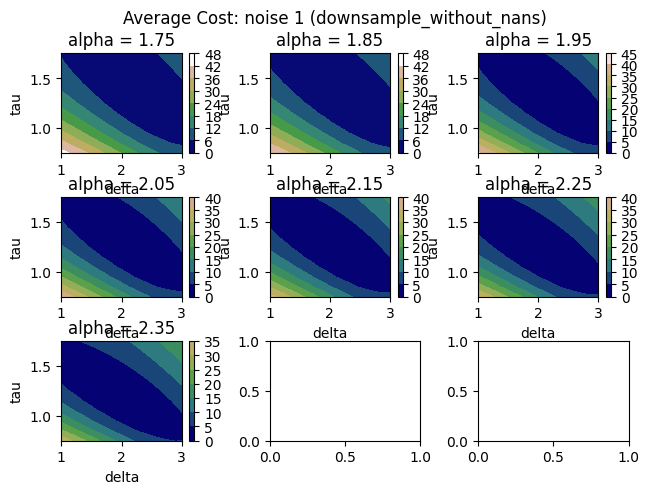

Minimal Cost for Average Cost: noise 2 (downsample_without_nans) = 4.007425574173477; at
      delta   tau  alpha
2076    2.3  1.25   1.95


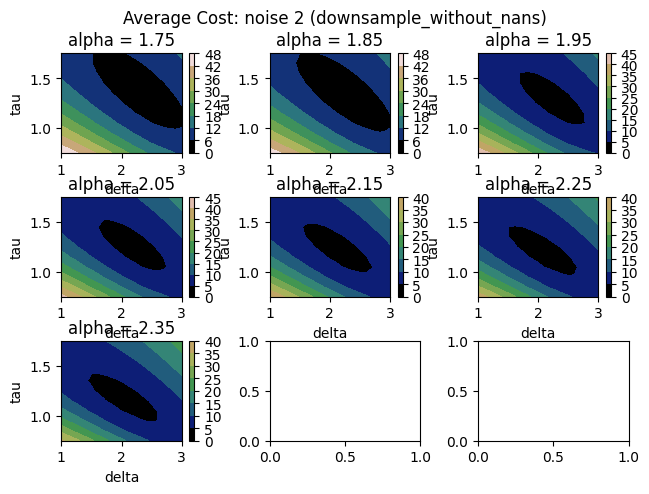

Minimal Cost for Average Cost: noise 3 (downsample_without_nans) = 9.01534277756694; at
      delta   tau  alpha
1924    2.2  1.25   2.05


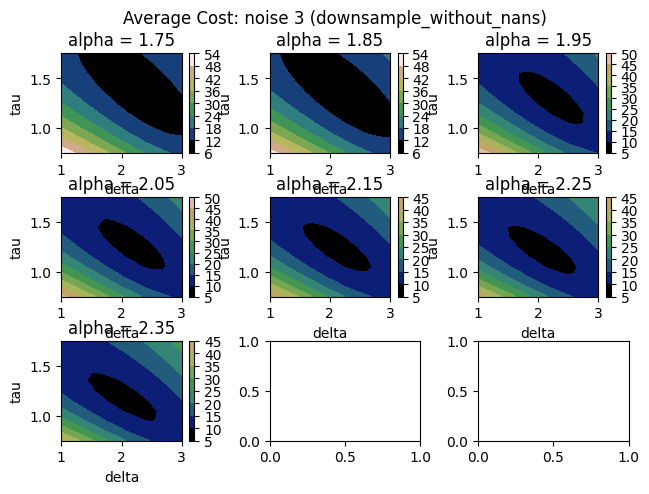

Minimal Cost for Average Cost: noise 4 (downsample_without_nans) = 15.940830873875191; at
      delta   tau  alpha
2076    2.3  1.25   1.95


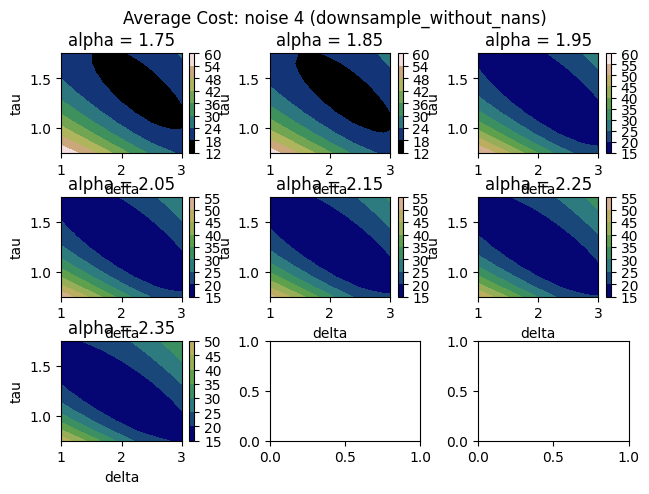

Minimal Cost for Average Cost: noise 5 (downsample_without_nans) = 25.12367861398815; at
      delta   tau  alpha
2076    2.3  1.25   1.95


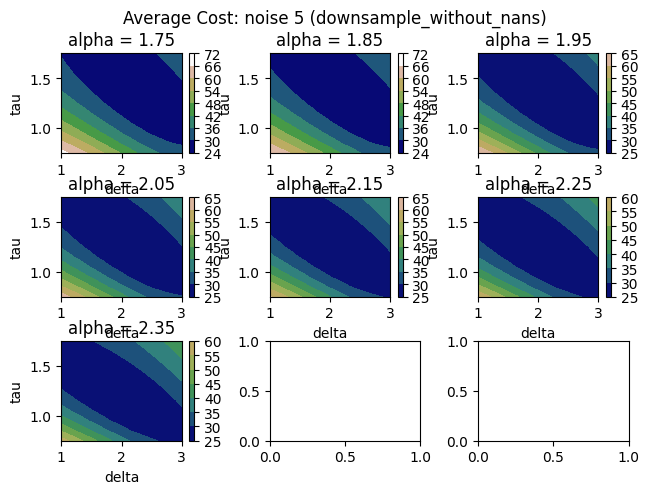

Minimal Cost for Average Cost: noise 6 (downsample_without_nans) = 35.770248802569725; at
      delta   tau  alpha
1924    2.2  1.25   2.05


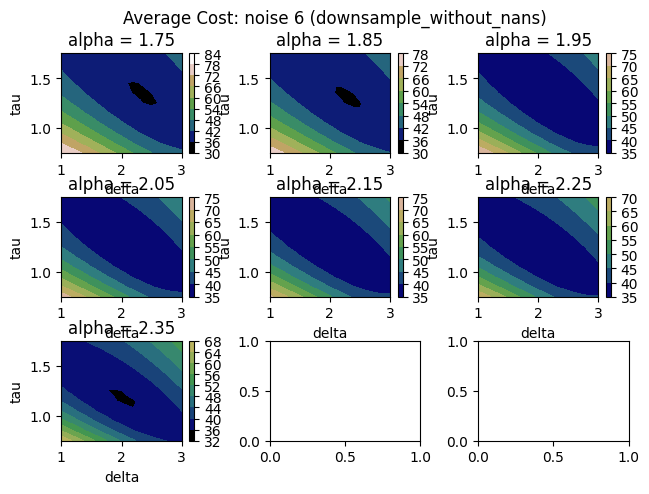

Minimal Cost for Average Cost: noise 7 (downsample_without_nans) = 49.332621726327496; at
      delta   tau  alpha
1924    2.2  1.25   2.05


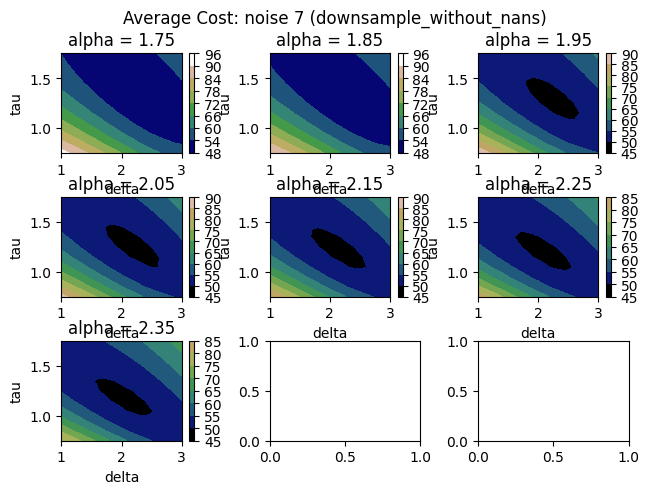

Minimal Cost for Average Cost: noise 8 (downsample_without_nans) = 64.2458461303117; at
      delta   tau  alpha
1924    2.2  1.25   2.05


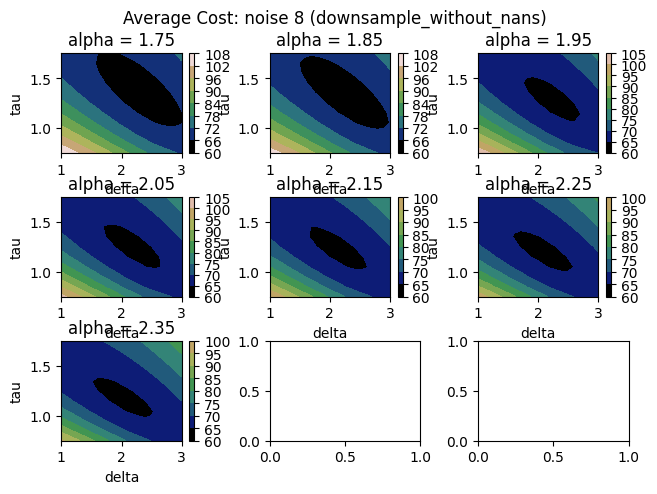

Minimal Cost for Average Cost: noise 9 (downsample_without_nans) = 80.57573125742961; at
      delta   tau  alpha
1924    2.2  1.25   2.05


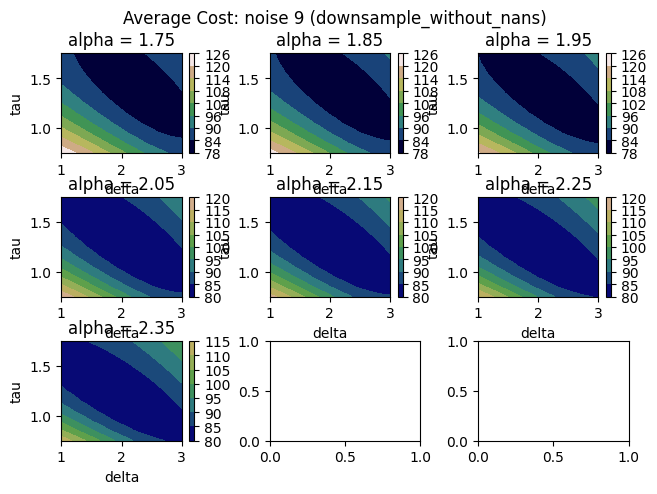

Minimal Cost for Average Cost: noise 10 (downsample_without_nans) = 99.78251634207432; at
      delta   tau  alpha
1924    2.2  1.25   2.05


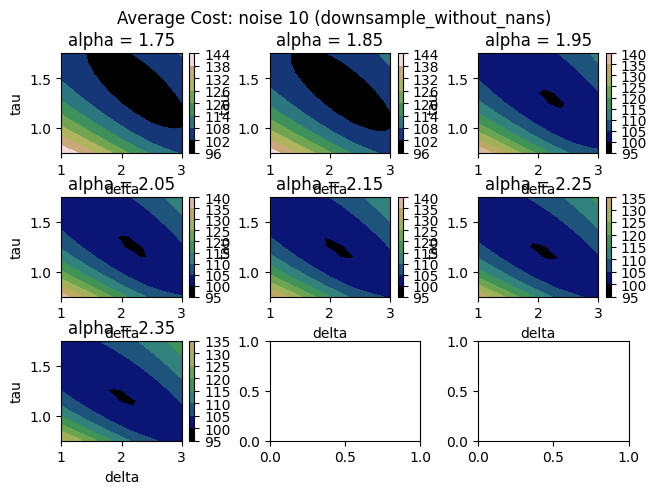

In [27]:
model_name = 'downsample_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

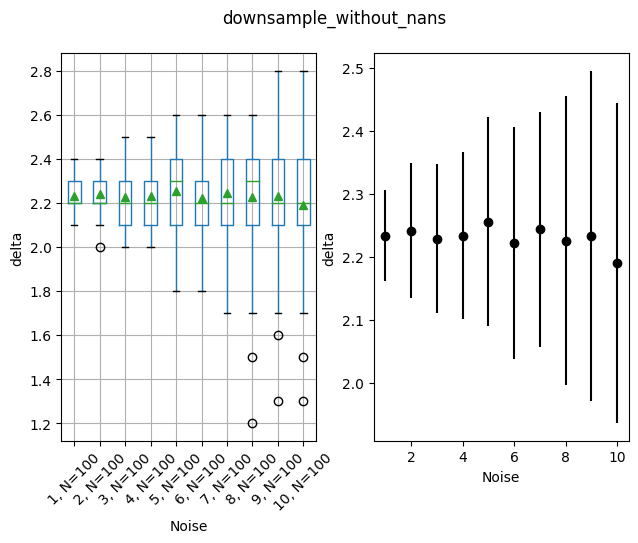

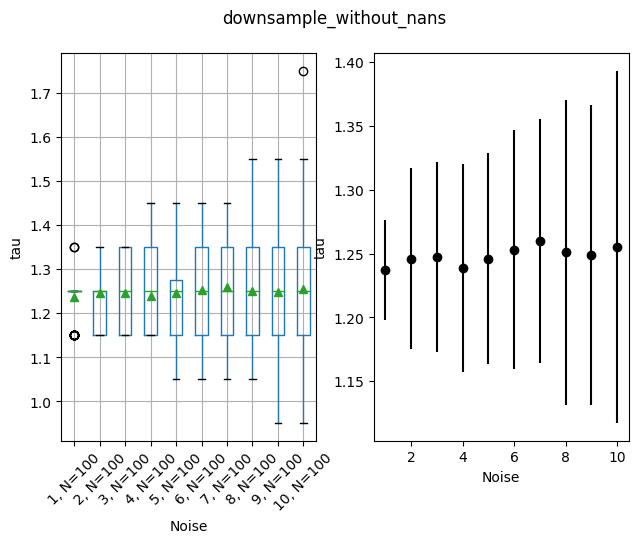

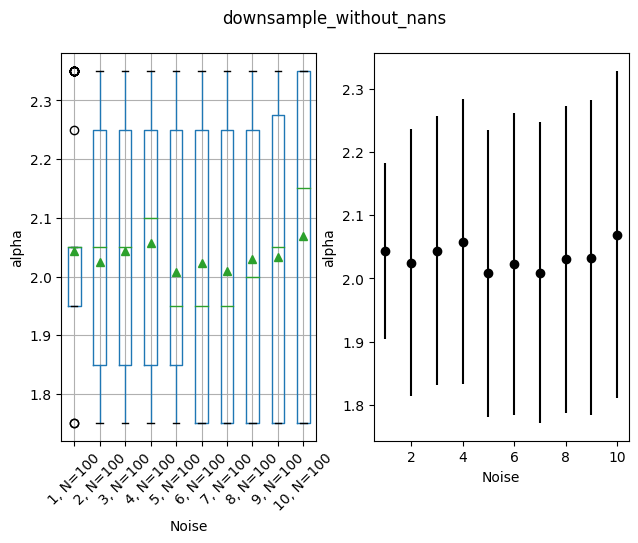

In [80]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans) = 1.0041457927170843; at
      delta   tau  alpha
2076    2.3  1.25   1.95


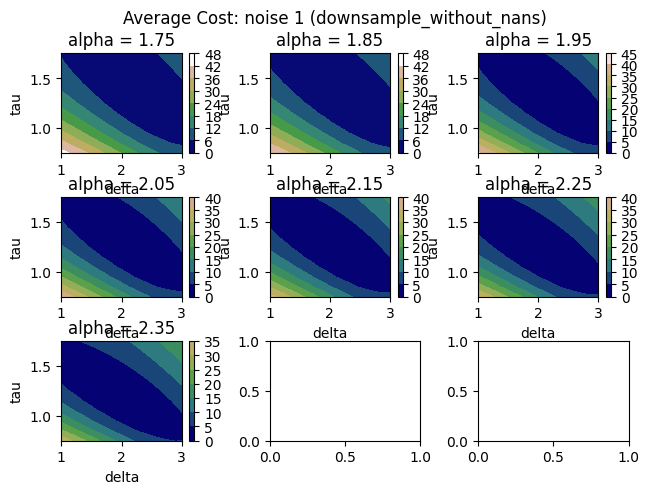

Minimal Cost for Average Cost: noise 2 (downsample_without_nans) = 4.007425574173477; at
      delta   tau  alpha
2076    2.3  1.25   1.95


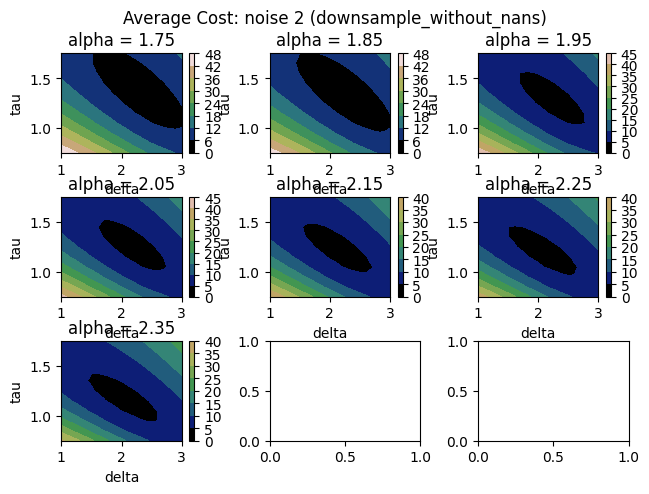

Minimal Cost for Average Cost: noise 3 (downsample_without_nans) = 9.01534277756694; at
      delta   tau  alpha
1924    2.2  1.25   2.05


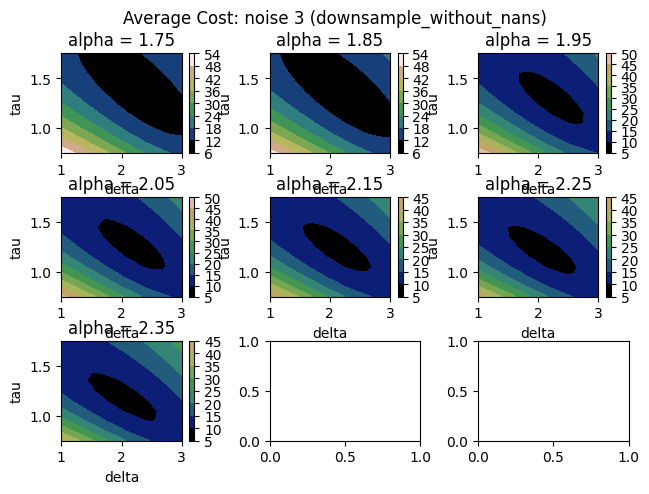

Minimal Cost for Average Cost: noise 4 (downsample_without_nans) = 15.940830873875191; at
      delta   tau  alpha
2076    2.3  1.25   1.95


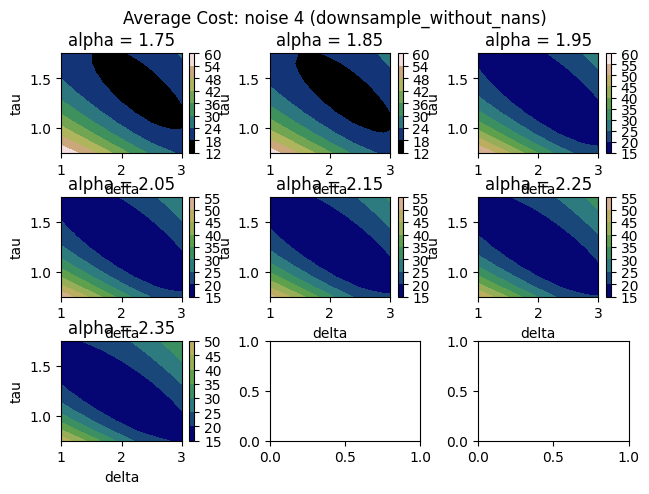

Minimal Cost for Average Cost: noise 5 (downsample_without_nans) = 25.12367861398815; at
      delta   tau  alpha
2076    2.3  1.25   1.95


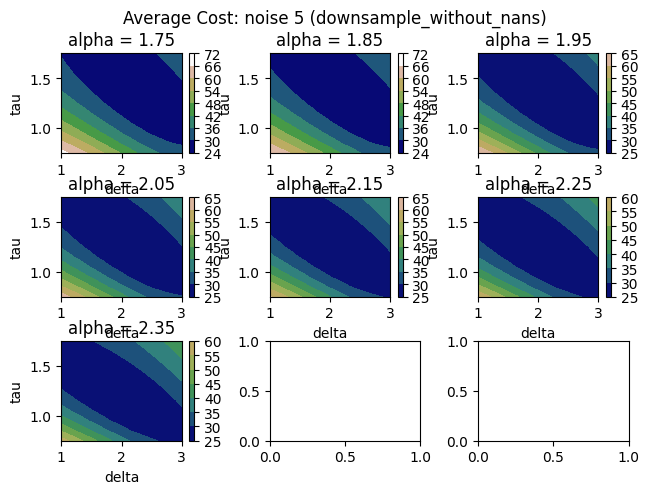

Minimal Cost for Average Cost: noise 6 (downsample_without_nans) = 35.770248802569725; at
      delta   tau  alpha
1924    2.2  1.25   2.05


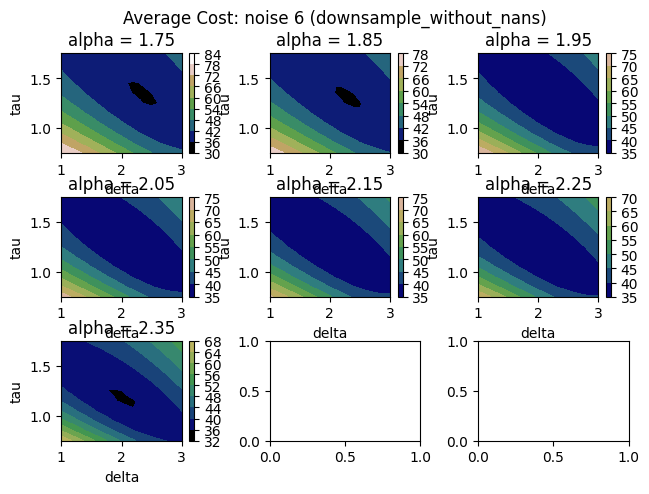

Minimal Cost for Average Cost: noise 7 (downsample_without_nans) = 49.332621726327496; at
      delta   tau  alpha
1924    2.2  1.25   2.05


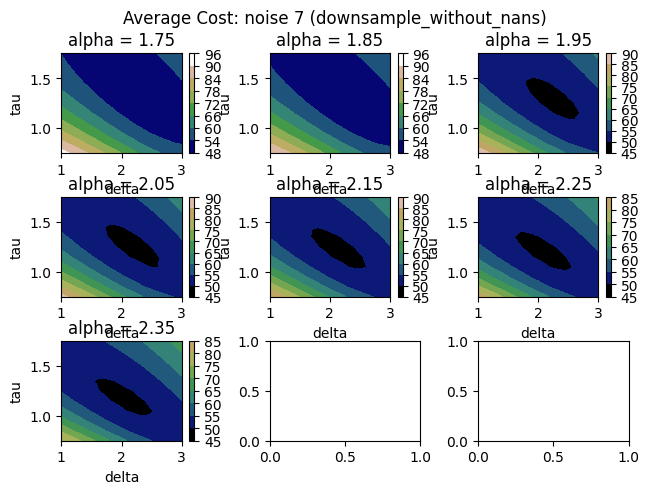

Minimal Cost for Average Cost: noise 8 (downsample_without_nans) = 64.2458461303117; at
      delta   tau  alpha
1924    2.2  1.25   2.05


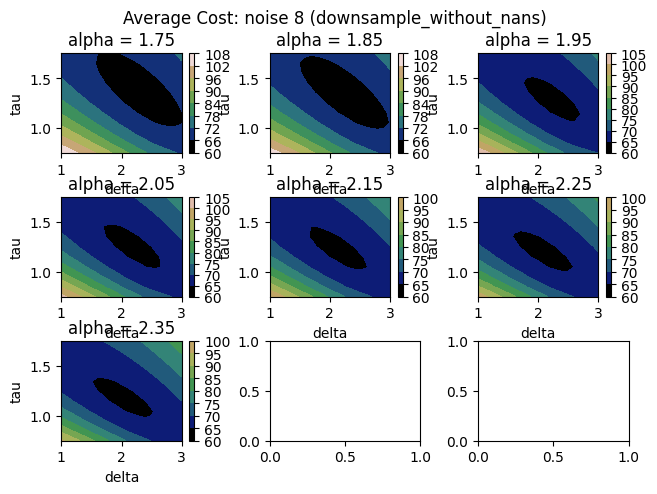

Minimal Cost for Average Cost: noise 9 (downsample_without_nans) = 80.57573125742961; at
      delta   tau  alpha
1924    2.2  1.25   2.05


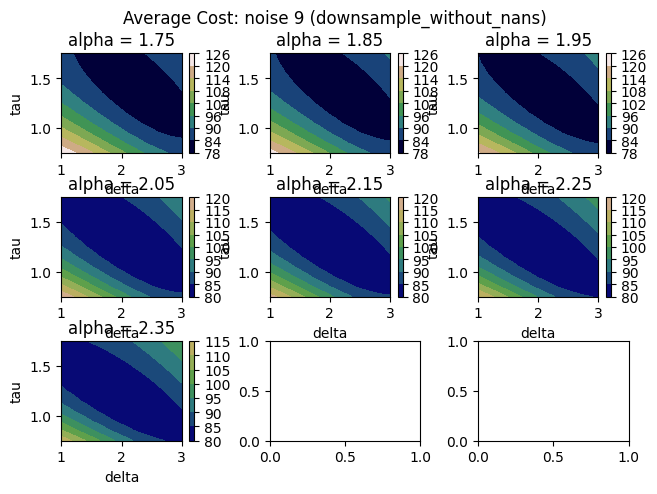

Minimal Cost for Average Cost: noise 10 (downsample_without_nans) = 99.78251634207432; at
      delta   tau  alpha
1924    2.2  1.25   2.05


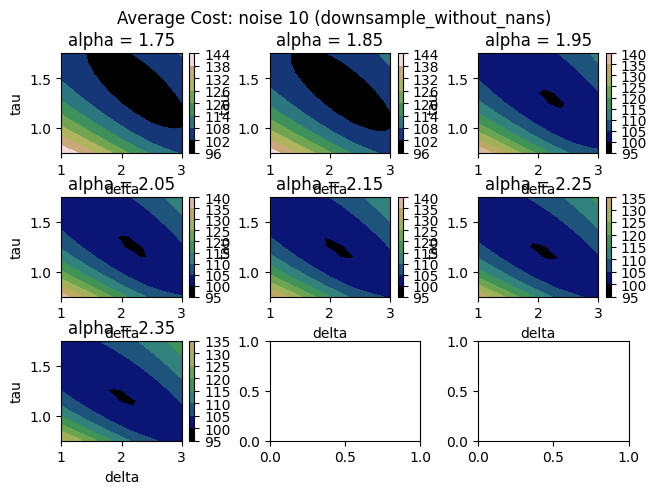

In [81]:
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


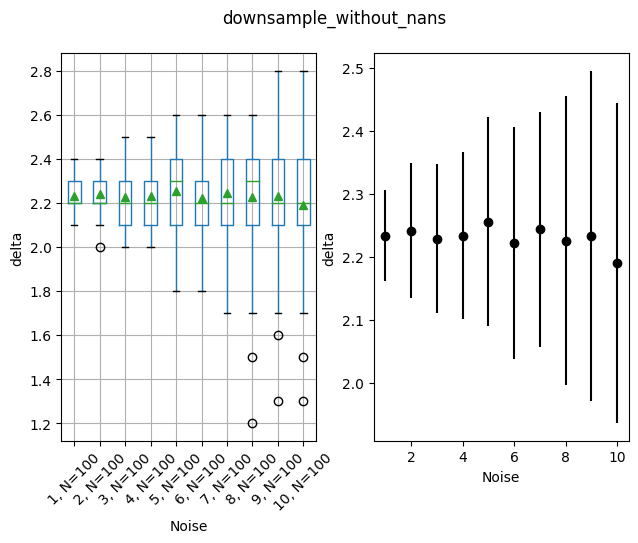

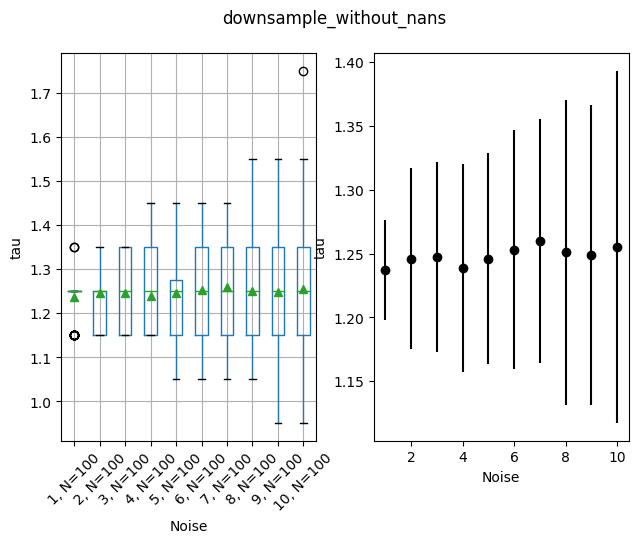

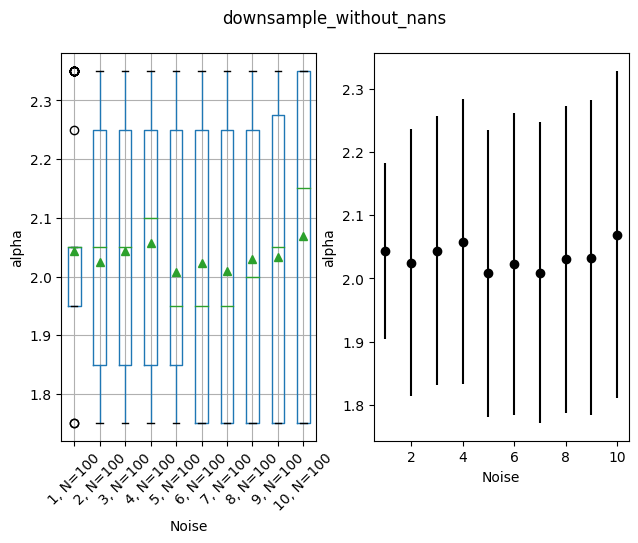

In [82]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [93]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans'


In [94]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [95]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        78    0.956259   2.000000000000001                1.15   
1         1         0    0.914294   2.100000000000001                1.15   
2         1         2    1.001621   2.100000000000001                1.15   
3         1         3    0.983118   2.100000000000001                1.15   
4         1         4    0.940242   2.100000000000001                1.15   
...     ...       ...         ...                 ...                 ...   
2260     10        18  107.867194  2.6000000000000014  1.3499999999999999   
2261     10        27   92.532737  2.7000000000000015  1.0499999999999998   
2262     10        32  101.463382  2.7000000000000015  1.0499999999999998   
2263     10        21  102.838518  2.7000000000000015                1.15   
2264     10        39   98.396033  2.8000000000000016                1.15   

                   alpha  
0     2.3500000000000005  
1     2.3500000000000005  
2     2.3500000000000005  
3     2.3500000000000005  
4     2.3500000000000005  
...                  ...  
2260                1.85  
2261                1.75  
2262  1.9500000000000002  
2263                1.75  
2264                1.75  

[2265 rows x 6 columns]

In [96]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
1                        2.67
2                        2.71
3                        2.46
4                        2.30
5                        2.29
6                        2.19
7                        2.13
8                        2.03
9                        1.98
10                       1.89

#### Local minima at edges

In [97]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [98]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [99]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [100]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration        cost               delta                 tau  \
2095     10        38  104.170554  1.9000000000000008  1.7499999999999998   

     alpha  
2095  1.75

In [102]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
199       1         2    0.986649   2.300000000000001  1.3499999999999999   
200       1         4    0.947560   2.300000000000001  1.3499999999999999   
201       1        12    1.046764   2.300000000000001  1.3499999999999999   
202       1        15    0.966499   2.300000000000001  1.3499999999999999   
203       1        22    1.018997   2.300000000000001  1.3499999999999999   
...     ...       ...         ...                 ...                 ...   
2258     10        13   99.361672  2.6000000000000014  1.3499999999999999   
2259     10        47  105.221402  2.6000000000000014  1.3499999999999999   
2261     10        27   92.532737  2.7000000000000015  1.0499999999999998   
2263     10        21  102.838518  2.7000000000000015                1.15   
2264     10        39   98.396033  2.8000000000000016                1.15   

     alpha  
199   1.75  
200   1.75  
201   1.75  
202   1.75  
203   1.75  
...    ...  
2258  1.75  
2259  1.75  
2261  1.75  
2263  1.75  
2264  1.75  

[484 rows x 6 columns]

In [103]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        67      2   2.300000000000001   36    67      1  1.3499999999999999   
10       39     11  2.4000000000000012    8    39      7  1.3499999999999999   
2        71      2  2.4000000000000012   39    71      1  1.3499999999999999   
3        50      4   2.300000000000001   25    50      3  1.3499999999999999   
4        42      4  2.4000000000000012   25    42      3  1.3499999999999999   
5        43      5  2.4000000000000012   18    43      3  1.3499999999999999   
6        45      5  2.4000000000000012   12    45      4  1.3499999999999999   
7        42      6  2.4000000000000012   14    42      4  1.3499999999999999   
8        41      9   2.300000000000001   10    41      6                1.25   
9        44      9  2.4000000000000012   14    44      5  1.3499999999999999   

            
      freq  
noise       
1       67  
10      19  
2       71  
3       48  
4       36  
5       31  
6       31  
7       22  
8       16  
9       18

In [104]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        78    0.956259   2.000000000000001                1.15   
1         1         0    0.914294   2.100000000000001                1.15   
2         1         2    1.001621   2.100000000000001                1.15   
3         1         3    0.983118   2.100000000000001                1.15   
4         1         4    0.940242   2.100000000000001                1.15   
...     ...       ...         ...                 ...                 ...   
2219     10        34  102.342033  2.4000000000000012                1.15   
2220     10        92  105.720952  2.4000000000000012                1.15   
2242     10        55   95.064849  2.5000000000000013  1.0499999999999998   
2253     10        32  101.451433  2.6000000000000014                0.95   
2254     10        39   98.526397  2.6000000000000014                0.95   

                   alpha  
0     2.3500000000000005  
1     2.3500000000000005  
2     2.3500000000000005  
3     2.3500000000000005  
4     2.3500000000000005  
...                  ...  
2219  2.3500000000000005  
2220  2.3500000000000005  
2242  2.3500000000000005  
2253  2.3500000000000005  
2254  2.3500000000000005  

[532 rows x 6 columns]

In [105]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                  tau                  
      count unique                top freq count unique   top freq
noise                                                             
1        97      2  2.100000000000001   96    97      1  1.15   97
10       50     12  2.200000000000001   14    50      6  1.15   22
2        73      3  2.100000000000001   66    73      1  1.15   73
3        51      3  2.100000000000001   39    51      1  1.15   51
4        51      5  2.100000000000001   35    51      3  1.15   48
5        43      5  2.000000000000001   13    43      3  1.15   37
6        41      7  2.200000000000001   14    41      3  1.15   32
7        44      8  2.100000000000001   13    44      3  1.15   29
8        43     10  2.300000000000001   12    43      5  1.15   21
9        39      9  2.100000000000001   10    39      5  1.15   22

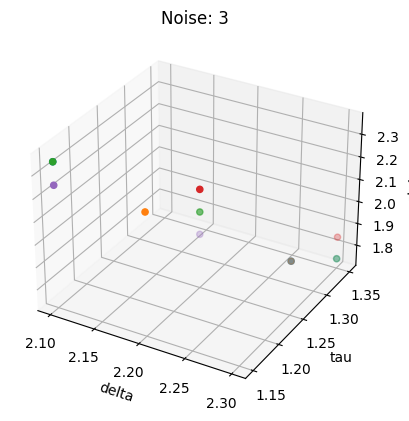

In [106]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

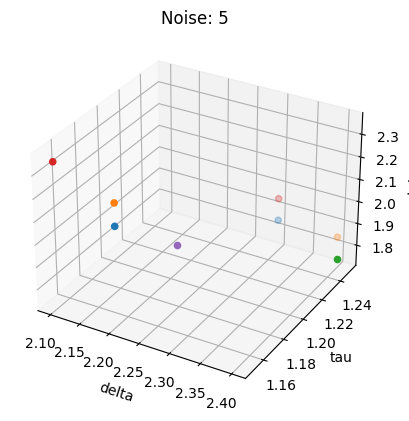

In [107]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

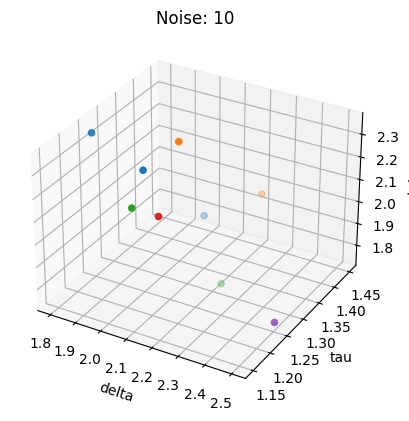

In [108]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [109]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_with_nans'


In [110]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [111]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         2    1.030751   2.100000000000001                1.15   
1         1        78    0.935683   2.100000000000001                1.15   
2         1         0    0.920632   2.100000000000001                1.15   
3         1         3    1.012346   2.100000000000001                1.15   
4         1         4    0.968982   2.100000000000001                1.15   
...     ...       ...         ...                 ...                 ...   
2219     10        55   93.856912  2.7000000000000015                1.15   
2220     10        18  110.082354  2.7000000000000015  1.3499999999999999   
2221     10        32  103.951787  2.8000000000000016                1.15   
2222     10        39   95.645100  2.8000000000000016                1.15   
2223     10        76  104.929713  3.0000000000000018                1.15   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.3500000000000005  
3     2.3500000000000005  
4     2.3500000000000005  
...                  ...  
2219                1.85  
2220                1.75  
2221                1.75  
2222                1.75  
2223                1.85  

[2224 rows x 6 columns]

In [112]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
1                        2.69
2                        2.63
3                        2.42
4                        2.22
5                        2.29
6                        2.12
7                        2.15
8                        1.93
9                        1.98
10                       1.81

#### Local minima at edges

In [113]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [114]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost               delta   tau alpha
1844      8         2   64.996175  3.0000000000000018  1.15  1.75
2223     10        76  104.929713  3.0000000000000018  1.15  1.85

In [115]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [116]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

noise iteration        cost               delta                 tau  \
2056     10        38  106.264989  1.8000000000000007  1.7499999999999998   

     alpha  
2056  1.75

In [117]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
199       1         2    1.011924   2.300000000000001  1.3499999999999999   
200       1         4    0.971268   2.300000000000001  1.3499999999999999   
201       1        12    1.055064   2.300000000000001  1.3499999999999999   
202       1        22    1.050967   2.300000000000001  1.3499999999999999   
203       1        23    0.985471   2.300000000000001  1.3499999999999999   
...     ...       ...         ...                 ...                 ...   
2215     10        25  105.478803  2.6000000000000014                1.25   
2217     10        13   97.973569  2.6000000000000014  1.3499999999999999   
2220     10        18  110.082354  2.7000000000000015  1.3499999999999999   
2221     10        32  103.951787  2.8000000000000016                1.15   
2222     10        39   95.645100  2.8000000000000016                1.15   

     alpha  
199   1.75  
200   1.75  
201   1.75  
202   1.75  
203   1.75  
...    ...  
2215  1.75  
2217  1.75  
2220  1.75  
2221  1.75  
2222  1.75  

[524 rows x 6 columns]

In [118]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        69      2  2.4000000000000012   39    69      1  1.3499999999999999   
10       41     12  2.4000000000000012    8    41      7                1.25   
2        65      4  2.4000000000000012   33    65      3  1.3499999999999999   
3        50      4   2.300000000000001   23    50      3  1.3499999999999999   
4        38      4  2.4000000000000012   20    38      3  1.3499999999999999   
5        57      8  2.4000000000000012   19    57      4  1.3499999999999999   
6        50      9   2.200000000000001   13    50      5  1.3499999999999999   
7        54      6   2.300000000000001   17    54      5  1.3499999999999999   
8        44      9  2.4000000000000012   10    44      5  1.3499999999999999   
9        56     11  2.4000000000000012   13    56      6  1.3499999999999999   

            
      freq  
noise       
1       69  
10       9  
2       63  
3       44  
4       29  
5       36  
6       19  
7       20  
8       21  
9       17

In [119]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
2         1         0    0.920632   2.100000000000001                1.15   
3         1         3    1.012346   2.100000000000001                1.15   
4         1         4    0.968982   2.100000000000001                1.15   
5         1         5    1.055041   2.100000000000001                1.15   
6         1         7    1.075994   2.100000000000001                1.15   
...     ...       ...         ...                 ...                 ...   
2179     10        18  110.185207  2.4000000000000012                1.15   
2180     10        34   91.349798  2.4000000000000012                1.15   
2181     10        92  109.765484  2.4000000000000012                1.15   
2197     10        89   97.539855  2.5000000000000013                1.15   
2218     10        76  104.909910  2.7000000000000015  1.0499999999999998   

                   alpha  
2     2.3500000000000005  
3     2.3500000000000005  
4     2.3500000000000005  
5     2.3500000000000005  
6     2.3500000000000005  
...                  ...  
2179  2.3500000000000005  
2180  2.3500000000000005  
2181  2.3500000000000005  
2197  2.3500000000000005  
2218  2.3500000000000005  

[514 rows x 6 columns]

In [120]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                  tau                  
      count unique                top freq count unique   top freq
noise                                                             
1        88      1  2.100000000000001   88    88      1  1.15   88
10       41     13  2.200000000000001   11    41      5  1.15   18
2        67      3  2.100000000000001   54    67      1  1.15   67
3        51      4  2.100000000000001   39    51      2  1.15   48
4        49      5  2.100000000000001   30    49      3  1.15   39
5        43      6  2.100000000000001   14    43      3  1.15   30
6        40      8  2.000000000000001   10    40      4  1.15   21
7        47      8  2.200000000000001   10    47      4  1.15   20
8        41     11  2.000000000000001   10    41      5  1.15   22
9        47     13  2.100000000000001    9    47      5  1.15   16

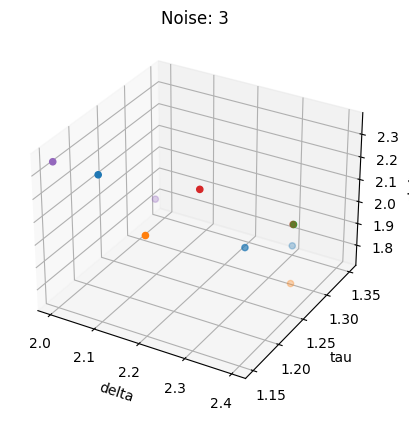

In [121]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

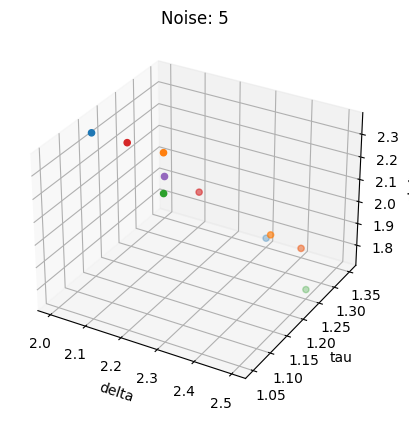

In [122]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

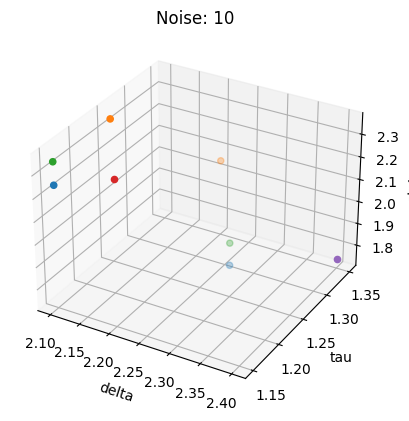

In [123]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()